In [10]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

import sys
sys.path.append('..')

In [11]:
res = pickle.load(open('../data/tfidf/initial_tests/175_results_v1.pkl', 'rb'))
len(res)

57

In [12]:
res[0]['metrics']

{'avg_precisions': [0.30991976345856986,
  0.18918650893215522,
  0.32662256542027884,
  0.1731264915564793,
  0.0895188994733224],
 'threshold_metrics': [{'threshold': 0.2746391579166245,
   'fold': 0,
   'precision': 0.24,
   'recall': 0.8,
   'filter_rate': 0.9755647763946519},
  {'threshold': 0.2675926667130443,
   'fold': 0,
   'precision': 0.23636363636363636,
   'recall': 0.8666666666666667,
   'filter_rate': 0.9737206085753803},
  {'threshold': 0.2177146397022452,
   'fold': 0,
   'precision': 0.11764705882352941,
   'recall': 0.9333333333333333,
   'filter_rate': 0.9446749654218534},
  {'threshold': 0.21318870985184998,
   'fold': 0,
   'precision': 0.11538461538461539,
   'recall': 1.0,
   'filter_rate': 0.9400645458736745},
  {'threshold': 0.2674660712221152,
   'fold': 1,
   'precision': 0.17647058823529413,
   'recall': 0.8,
   'filter_rate': 0.9672660212079299},
  {'threshold': 0.26401612431546445,
   'fold': 1,
   'precision': 0.17567567567567569,
   'recall': 0.86666666

In [13]:
"""
Now we'll transform the results into:

metrics_summary = {
    'avg_precisions': [.54, .483, ...],
    'recall95_filterrates': [.56, .84, ...],
    'recall95_thresholds': [.56, .84, ...],
    'recall98_filterrates': [.56, .84, ...],
    'recall98_thresholds': [.56, .84, ...],
    'recall100_filterrates': [.56, .84, ...],
    'recall100_thresholds': [.56, .84, ...],
}
# Pareto frontier points. Each is a (recall, filterrate, threshold)
recall_filterrates = [
	# Fold 0
	[(.5, .95, 0.3), (.63, .83, 0.2), ...],
	# Fold 1
	[(.5, .95, 0.3), (.63, .83, 0.2), ...],
	...
]
"""
critical_recalls = [1.0, .99, .98, .96, .94, .9]
cv_folds = 5

def summarize_metrics(metrics):
    all_recall_filterrates = [[] for n in range(cv_folds)]
    for threshold_option in metrics['threshold_metrics']:
        all_recall_filterrates[threshold_option['fold']].append(
            (threshold_option['recall'], threshold_option['filter_rate'], threshold_option['threshold'])
        )

    # Sort each list of fold points by recall ascending
    all_recall_filterrates = [list(sorted(options, key=lambda m: m[0])) for options in all_recall_filterrates]

    # {90: [(filterrate, threshold) for each fold], 95: [], ...}
    critical_folds = dict([(recall, []) for recall in critical_recalls])
    for recall in critical_recalls:
        for fold_options in all_recall_filterrates:
            for option in fold_options:
                if option[0] >= recall:
                    critical_folds[recall].append((option[1], option[2]))
                    break

    summary = {'avg_precisions': metrics['avg_precisions']}
    for recall in critical_recalls:
        summary[f'recall{recall * 100:.0f}_filterrates'] = [round(pair[0], 4) for pair in critical_folds[recall]]
        summary[f'recall{recall * 100:.0f}_thresholds'] = [round(pair[1], 4) for pair in critical_folds[recall]]

    return summary, all_recall_filterrates

summarize_metrics(res[30]['metrics'])

({'avg_precisions': [0.32326828698140736,
   0.3452110501436651,
   0.4007603218600495,
   0.2979268748979047,
   0.09812230538462167],
  'recall100_filterrates': [0.9488, 0.97, 0.9511, 0.9046, 0.863],
  'recall100_thresholds': [0.2747, 0.4281, 0.2541, 0.1762, 0.1358],
  'recall99_filterrates': [0.9488, 0.97, 0.9511, 0.9046, 0.863],
  'recall99_thresholds': [0.2747, 0.4281, 0.2541, 0.1762, 0.1358],
  'recall98_filterrates': [0.9488, 0.97, 0.9511, 0.9046, 0.863],
  'recall98_thresholds': [0.2747, 0.4281, 0.2541, 0.1762, 0.1358],
  'recall96_filterrates': [0.9488, 0.97, 0.9511, 0.9046, 0.863],
  'recall96_thresholds': [0.2747, 0.4281, 0.2541, 0.1762, 0.1358],
  'recall94_filterrates': [0.9488, 0.97, 0.9511, 0.9046, 0.863],
  'recall94_thresholds': [0.2747, 0.4281, 0.2541, 0.1762, 0.1358],
  'recall90_filterrates': [0.953, 0.97, 0.9576, 0.9336, 0.8833],
  'recall90_thresholds': [0.3044, 0.4302, 0.2782, 0.2235, 0.1492]},
 [[(0.8, 0.9741816505301982, 0.4586789956785678),
   (0.8666666666666

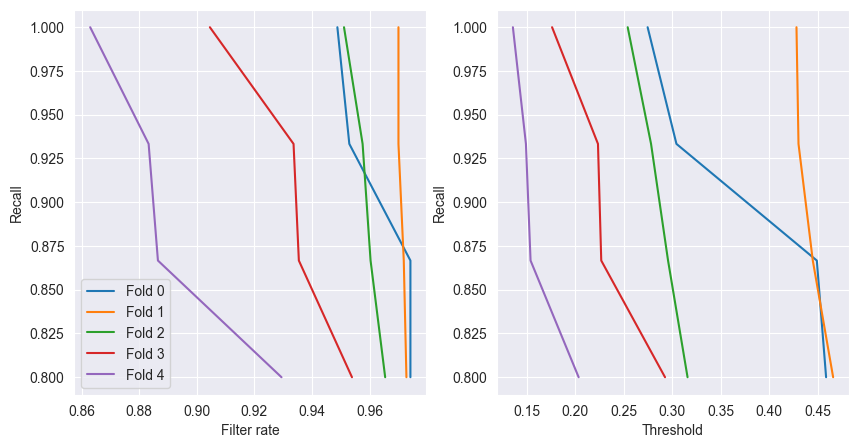

In [14]:
# The filterrate achieved at different recall points varies per fold
# Also, the ideal decision thresholds to achieve these recalls varies quiet a bit (correlated with filter rate)
#TODO try another case or two
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for fold_i, fold_options in enumerate(summarize_metrics(res[30]['metrics'])[1]):
    # X axis will be filter rate, Y axis recall
    ax[0].plot([option[1] for option in fold_options], [option[0] for option in fold_options], label=f'Fold {fold_i}')
    ax[1].plot([option[2] for option in fold_options], [option[0] for option in fold_options], label=f'Fold {fold_i}')

ax[0].set_xlabel('Filter rate')
ax[0].set_ylabel('Recall')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Recall')
ax[0].legend()

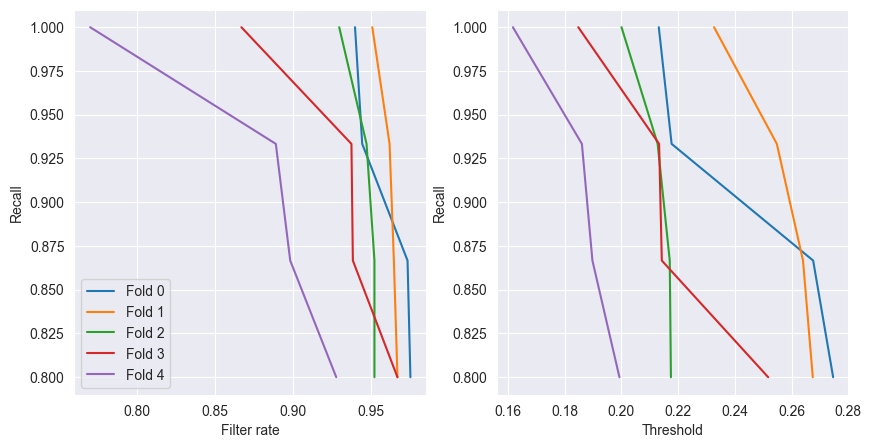

In [15]:
# A different random model for case 175
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for fold_i, fold_options in enumerate(summarize_metrics(res[0]['metrics'])[1]):
    # X axis will be filter rate, Y axis recall
    ax[0].plot([option[1] for option in fold_options], [option[0] for option in fold_options], label=f'Fold {fold_i}')
    ax[1].plot([option[2] for option in fold_options], [option[0] for option in fold_options], label=f'Fold {fold_i}')

ax[0].set_xlabel('Filter rate')
ax[0].set_ylabel('Recall')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Recall')
ax[0].legend()

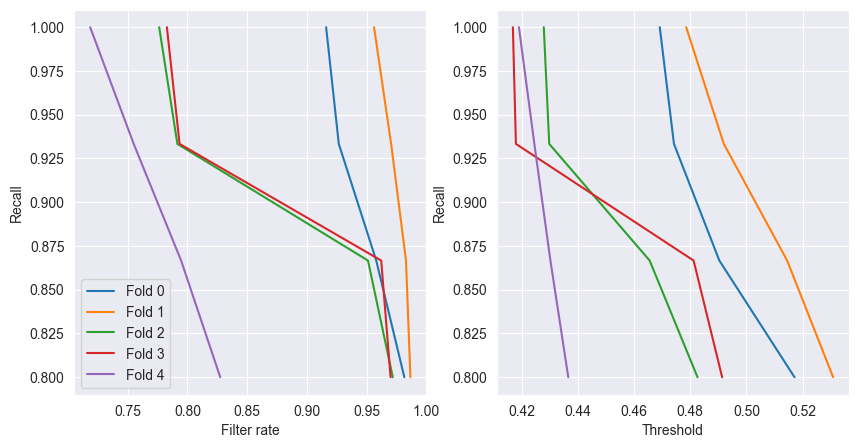

In [16]:
# Are random forest classifier probabilities any better calibrated across folds? Looks like yes
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for fold_i, fold_options in enumerate(summarize_metrics(res[48]['metrics'])[1]):
    # X axis will be filter rate, Y axis recall
    ax[0].plot([option[1] for option in fold_options], [option[0] for option in fold_options], label=f'Fold {fold_i}')
    ax[1].plot([option[2] for option in fold_options], [option[0] for option in fold_options], label=f'Fold {fold_i}')

ax[0].set_xlabel('Filter rate')
ax[0].set_ylabel('Recall')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Recall')
ax[0].legend()

Text(0, 0.5, 'Recall')

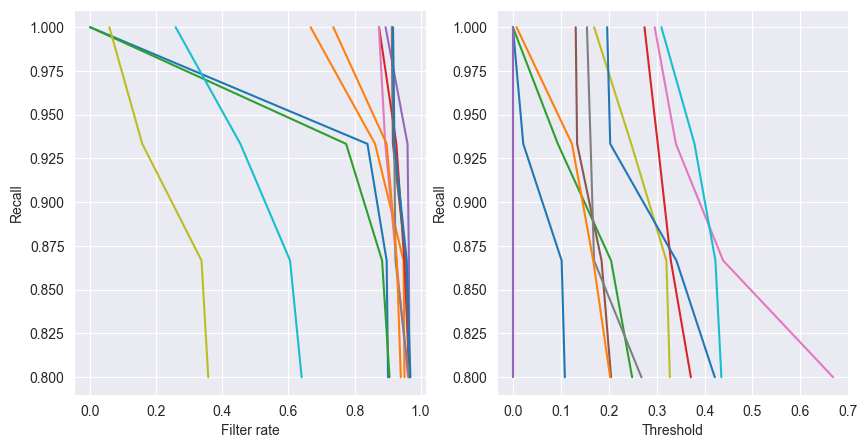

In [17]:
# Fold 3s for a bunch of models
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

n_models = 12
for i in np.random.choice(np.arange(len(res)), size=n_models, replace=False):
    fold3_points = summarize_metrics(res[i]['metrics'])[1][3]
    # X axis will be filter rate, Y axis recall
    ax[0].plot([option[1] for option in fold3_points], [option[0] for option in fold3_points])
    ax[1].plot([option[2] for option in fold3_points], [option[0] for option in fold3_points])

ax[0].set_xlabel('Filter rate')
ax[0].set_ylabel('Recall')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Recall')

Text(0, 0.5, 'Recall')

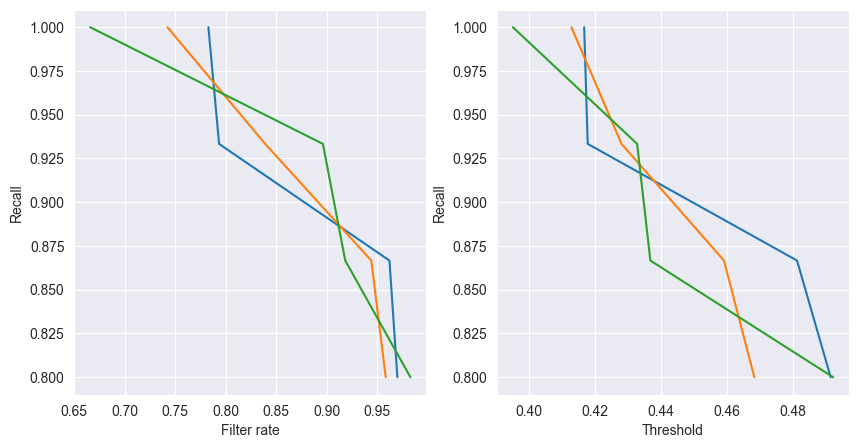

In [18]:
# Fold 3s for random forests, showing better calibration
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(len(res)):
    if res[i]['model_class'].__name__ != 'RandomForestClassifier':
        continue
    fold3_points = summarize_metrics(res[i]['metrics'])[1][3]
    # X axis will be filter rate, Y axis recall
    ax[0].plot([option[1] for option in fold3_points], [option[0] for option in fold3_points])
    ax[1].plot([option[2] for option in fold3_points], [option[0] for option in fold3_points])

ax[0].set_xlabel('Filter rate')
ax[0].set_ylabel('Recall')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Recall')

In [19]:
# Now, summarize the metrics across folds to compare final models
def summarize_all_metrics(results):
    res_df = []
    for model in results:
        model_dict = {
            'model_class': model['model_class'].__name__,
            'rebalance_to': model['rebalance_to'],
        } | model['model_kwargs']
        metrics_summary = summarize_metrics(model['metrics'])[0]
        model_dict['avg_precision'] = np.mean(metrics_summary['avg_precisions'])
        for recall in critical_recalls:
            recall_str = f"recall{recall * 100:.0f}"
            model_dict[f'{recall_str}_filterrate'] = np.mean(metrics_summary[f'{recall_str}_filterrates'])
            model_dict[f'{recall_str}_threshold_cv'] = (np.std(metrics_summary[f'{recall_str}_thresholds']) /
                                                        np.mean(metrics_summary[f'{recall_str}_thresholds']))

        res_df.append(model_dict)

    return pd.DataFrame(res_df)

res_df = summarize_all_metrics(res)

In [20]:
eval_cols = ['avg_precision', 'recall100_filterrate', 'recall90_filterrate', 'recall100_threshold_cv', 'recall90_threshold_cv']
res_df.sort_values('recall100_filterrate', ascending=False)[['model_class'] + eval_cols].round(4)

,model_class,avg_precision,recall100_filterrate,recall90_filterrate,recall100_threshold_cv,recall90_threshold_cv
24,SGDClassifier,0.2872,0.9289,0.9354,0.3270,0.3323
30,SGDClassifier,0.2931,0.9275,0.9395,0.3970,0.3363
35,SGDClassifier,0.2906,0.9256,0.9370,0.3739,0.3297
34,SGDClassifier,0.2871,0.9234,0.9399,0.3821,0.3248
31,SGDClassifier,0.2862,0.9230,0.9413,0.3991,0.3242
29,SGDClassifier,0.2807,0.9222,0.9403,0.3804,0.3170
27,SGDClassifier,0.2644,0.9221,0.9333,0.3828,0.3449
25,SGDClassifier,0.2713,0.9197,0.9308,0.3779,0.3524
26,SGDClassifier,0.2583,0.9183,0.9401,0.4192,0.3422
28,SGDClassifier,0.2655,0.9167,0.9438,0.2879,0.2221


In [21]:
# Threshold coefficients of variation above .5 are realistically not in play because I need to trust the final threshold
# (not enough data for a holdout set in many cases). I will filter these out, and define a summary metric for filtrate plus
# low coefficient variation
res_df['score'] = res_df.recall100_filterrate + (1 - res_df.recall100_threshold_cv)
eval_cols = ['score', 'recall100_filterrate', 'recall90_filterrate', 'recall100_threshold_cv', 'avg_precision']
res_df[res_df.recall100_threshold_cv < .5].sort_values('score', ascending=False)[['model_class'] + eval_cols].round(4)

,model_class,score,recall100_filterrate,recall90_filterrate,recall100_threshold_cv,avg_precision
48,RandomForestClassifier,1.7708,0.8300,0.8475,0.0592,0.4459
0,LogisticRegression,1.7699,0.8917,0.9363,0.1218,0.2177
50,RandomForestClassifier,1.7649,0.8288,0.8941,0.0639,0.4864
49,RandomForestClassifier,1.7573,0.8289,0.8776,0.0716,0.4657
1,LogisticRegression,1.7518,0.8945,0.9345,0.1427,0.2320
4,LogisticRegression,1.7313,0.8904,0.9396,0.1592,0.2389
8,LogisticRegression,1.7107,0.8930,0.9424,0.1823,0.2474
12,LogisticRegression,1.7103,0.8558,0.9200,0.1456,0.2381
13,LogisticRegression,1.7098,0.8827,0.9177,0.1729,0.2313
32,SGDClassifier,1.6978,0.8962,0.9423,0.1984,0.2507


In [22]:
# Rebalancing and class weight doesn't seem to matter for SGDClassifier. Logistic regression probably better without rebalancing.
# Logistic regression has much much better calibrated thresholds for smaller class weights
res_df[res_df.recall100_threshold_cv < .5].sort_values('score', ascending=False)[['model_class', 'rebalance_to', 'class_weight'] + eval_cols].round(4)

,model_class,rebalance_to,class_weight,score,recall100_filterrate,recall90_filterrate,recall100_threshold_cv,avg_precision
48,RandomForestClassifier,20.0,balanced_subsample,1.7708,0.8300,0.8475,0.0592,0.4459
0,LogisticRegression,20.0,"{0: 1.0, 1: 5.0}",1.7699,0.8917,0.9363,0.1218,0.2177
50,RandomForestClassifier,NaN,balanced_subsample,1.7649,0.8288,0.8941,0.0639,0.4864
49,RandomForestClassifier,60.0,balanced_subsample,1.7573,0.8289,0.8776,0.0716,0.4657
1,LogisticRegression,20.0,"{0: 1.0, 1: 10.0}",1.7518,0.8945,0.9345,0.1427,0.2320
4,LogisticRegression,60.0,"{0: 1.0, 1: 5.0}",1.7313,0.8904,0.9396,0.1592,0.2389
8,LogisticRegression,NaN,"{0: 1.0, 1: 5.0}",1.7107,0.8930,0.9424,0.1823,0.2474
12,LogisticRegression,20.0,"{0: 1.0, 1: 5.0}",1.7103,0.8558,0.9200,0.1456,0.2381
13,LogisticRegression,20.0,"{0: 1.0, 1: 10.0}",1.7098,0.8827,0.9177,0.1729,0.2313
32,SGDClassifier,NaN,"{0: 1.0, 1: 5.0}",1.6978,0.8962,0.9423,0.1984,0.2507


In [23]:
# Huber loss is not performing well. Nor is naiive bayes and I'm not sure why
res_df[res_df.recall100_threshold_cv < .5].sort_values('score', ascending=False)[['model_class', 'loss', 'penalty'] + eval_cols].round(4)

,model_class,loss,penalty,score,recall100_filterrate,recall90_filterrate,recall100_threshold_cv,avg_precision
48,RandomForestClassifier,NaN,NaN,1.7708,0.8300,0.8475,0.0592,0.4459
0,LogisticRegression,NaN,l2,1.7699,0.8917,0.9363,0.1218,0.2177
50,RandomForestClassifier,NaN,NaN,1.7649,0.8288,0.8941,0.0639,0.4864
49,RandomForestClassifier,NaN,NaN,1.7573,0.8289,0.8776,0.0716,0.4657
1,LogisticRegression,NaN,l2,1.7518,0.8945,0.9345,0.1427,0.2320
4,LogisticRegression,NaN,l2,1.7313,0.8904,0.9396,0.1592,0.2389
8,LogisticRegression,NaN,l2,1.7107,0.8930,0.9424,0.1823,0.2474
12,LogisticRegression,NaN,elasticnet,1.7103,0.8558,0.9200,0.1456,0.2381
13,LogisticRegression,NaN,elasticnet,1.7098,0.8827,0.9177,0.1729,0.2313
32,SGDClassifier,log_loss,l2,1.6978,0.8962,0.9423,0.1984,0.2507


In [24]:
# Confirming the above results for two other cases 216 and 232, ran with a slightly smaller search space
res216 = pickle.load(open('../data/tfidf/initial_tests/216_results_v1.pkl', 'rb'))
print(len(res216))
res216_df = summarize_all_metrics(res216)
res216_df['score'] = res216_df.recall100_filterrate + (1 - res216_df.recall100_threshold_cv)
res216_df[res216_df.recall100_threshold_cv < .5].sort_values('score', ascending=False)[['model_class'] + eval_cols].round(4)

23


,model_class,score,recall100_filterrate,recall90_filterrate,recall100_threshold_cv,avg_precision
22,RandomForestClassifier,1.7421,0.8066,0.9324,0.0645,0.6114
0,LogisticRegression,1.7347,0.9181,0.9609,0.1835,0.3138
20,RandomForestClassifier,1.7273,0.7865,0.9495,0.0593,0.6463
16,SGDClassifier,1.7187,0.9188,0.9616,0.2001,0.3169
4,LogisticRegression,1.6772,0.9148,0.9568,0.2376,0.3140
1,LogisticRegression,1.6585,0.9235,0.9632,0.2650,0.3286
12,SGDClassifier,1.6412,0.9237,0.9634,0.2825,0.3261
17,SGDClassifier,1.6392,0.9245,0.9633,0.2854,0.3309
21,RandomForestClassifier,1.6343,0.7175,0.9438,0.0832,0.6478
2,LogisticRegression,1.6192,0.9374,0.9642,0.3182,0.3302


In [25]:
res216_df[res216_df.recall100_threshold_cv < .5].sort_values('score', ascending=False)[['model_class', 'rebalance_to', 'class_weight'] + eval_cols].round(4)

,model_class,rebalance_to,class_weight,score,recall100_filterrate,recall90_filterrate,recall100_threshold_cv,avg_precision
22,RandomForestClassifier,NaN,balanced_subsample,1.7421,0.8066,0.9324,0.0645,0.6114
0,LogisticRegression,NaN,"{0: 1.0, 1: 5.0}",1.7347,0.9181,0.9609,0.1835,0.3138
20,RandomForestClassifier,20.0,balanced_subsample,1.7273,0.7865,0.9495,0.0593,0.6463
16,SGDClassifier,NaN,"{0: 1.0, 1: 5.0}",1.7187,0.9188,0.9616,0.2001,0.3169
4,LogisticRegression,NaN,"{0: 1.0, 1: 5.0}",1.6772,0.9148,0.9568,0.2376,0.3140
1,LogisticRegression,NaN,"{0: 1.0, 1: 10.0}",1.6585,0.9235,0.9632,0.2650,0.3286
12,SGDClassifier,60.0,"{0: 1.0, 1: 5.0}",1.6412,0.9237,0.9634,0.2825,0.3261
17,SGDClassifier,NaN,"{0: 1.0, 1: 10.0}",1.6392,0.9245,0.9633,0.2854,0.3309
21,RandomForestClassifier,60.0,balanced_subsample,1.6343,0.7175,0.9438,0.0832,0.6478
2,LogisticRegression,NaN,"{0: 1.0, 1: 30.0}",1.6192,0.9374,0.9642,0.3182,0.3302


In [26]:
# Much less success filtering for random forests here
res232 = pickle.load(open('../data/tfidf/initial_tests/232_results_v1.pkl', 'rb'))
print(len(res232))
res232_df = summarize_all_metrics(res232)
res232_df['score'] = res232_df.recall100_filterrate + (1 - res232_df.recall100_threshold_cv)
res232_df[res232_df.recall100_threshold_cv < .5].sort_values('score', ascending=False)[['model_class'] + eval_cols].round(4)

23


,model_class,score,recall100_filterrate,recall90_filterrate,recall100_threshold_cv,avg_precision
0,LogisticRegression,1.6552,0.8653,0.8653,0.2101,0.2640
4,LogisticRegression,1.6489,0.8657,0.8657,0.2168,0.2919
16,SGDClassifier,1.6253,0.8650,0.8650,0.2397,0.2730
20,RandomForestClassifier,1.5536,0.6362,0.6362,0.0826,0.3777
5,LogisticRegression,1.5512,0.8288,0.8288,0.2776,0.3059
1,LogisticRegression,1.5453,0.8521,0.8521,0.3068,0.2816
17,SGDClassifier,1.5156,0.8426,0.8426,0.3270,0.2825
21,RandomForestClassifier,1.5109,0.5923,0.5923,0.0814,0.4080
22,RandomForestClassifier,1.4964,0.5695,0.5695,0.0731,0.4645
12,SGDClassifier,1.4143,0.8372,0.8372,0.4228,0.2886


For the next round:
- lower class weight options, no more 30:1 or 80:1
- more random forest hyperparams

In [31]:
res175 = pickle.load(open('../data/tfidf/initial_tests/175_results_v2.pkl', 'rb'))
print(len(res175))
res175_df = summarize_all_metrics(res175)
res175_df['score'] = res175_df.recall100_filterrate + (1 - res175_df.recall100_threshold_cv)
res175_df[res175_df.recall100_threshold_cv < .5].sort_values('score', ascending=False)[['model_class', 'rebalance_to', 'class_weight'] + eval_cols].round(4)

34


,model_class,rebalance_to,class_weight,score,recall100_filterrate,recall90_filterrate,recall100_threshold_cv,avg_precision
20,SGDClassifier,NaN,"{0: 1.0, 1: 1.0}",1.8106,0.8624,0.9383,0.0518,0.2347
4,LogisticRegression,NaN,"{0: 1.0, 1: 1.0}",1.8077,0.8568,0.9318,0.0490,0.2214
0,LogisticRegression,20.0,"{0: 1.0, 1: 1.0}",1.8062,0.8531,0.9355,0.0469,0.2131
1,LogisticRegression,20.0,"{0: 1.0, 1: 3.0}",1.7848,0.8813,0.9353,0.0966,0.2152
25,RandomForestClassifier,NaN,balanced_subsample,1.7808,0.8099,0.8790,0.0291,0.4743
2,LogisticRegression,20.0,"{0: 1.0, 1: 5.0}",1.7767,0.8916,0.9393,0.1149,0.2203
31,RandomForestClassifier,NaN,balanced_subsample,1.7583,0.8125,0.8687,0.0542,0.4275
5,LogisticRegression,NaN,"{0: 1.0, 1: 3.0}",1.7493,0.8774,0.9404,0.1280,0.2345
9,LogisticRegression,20.0,"{0: 1.0, 1: 3.0}",1.7489,0.8417,0.9169,0.0927,0.2173
10,LogisticRegression,20.0,"{0: 1.0, 1: 5.0}",1.7438,0.8719,0.9069,0.1281,0.2101


In [32]:
# No clear winner for optimal regularization hyperparams
res175_df[(res175_df.recall100_threshold_cv < .5) & res175_df.max_depth.notna()].sort_values('score', ascending=False)[['model_class', 'max_depth', 'min_samples_split'] + eval_cols].round(4)

,model_class,max_depth,min_samples_split,score,recall100_filterrate,recall90_filterrate,recall100_threshold_cv,avg_precision
25,RandomForestClassifier,3.0,8.0,1.7808,0.8099,0.8790,0.0291,0.4743
31,RandomForestClassifier,5.0,4.0,1.7583,0.8125,0.8687,0.0542,0.4275
29,RandomForestClassifier,10.0,8.0,1.7406,0.8539,0.9021,0.1133,0.5051
32,RandomForestClassifier,5.0,12.0,1.7179,0.7760,0.8437,0.0581,0.3945
24,RandomForestClassifier,3.0,8.0,1.6600,0.7100,0.8517,0.0500,0.4564
28,RandomForestClassifier,10.0,8.0,1.6584,0.7812,0.8537,0.1227,0.4467
27,RandomForestClassifier,5.0,8.0,1.6400,0.7052,0.8517,0.0652,0.4255
33,RandomForestClassifier,5.0,12.0,1.6083,0.6778,0.8525,0.0695,0.4524
30,RandomForestClassifier,5.0,4.0,1.5804,0.6501,0.8826,0.0697,0.4471
26,RandomForestClassifier,5.0,8.0,1.5013,0.5871,0.8439,0.0858,0.4009


In [33]:
res216 = pickle.load(open('../data/tfidf/initial_tests/216_results_v2.pkl', 'rb'))
res216_df = summarize_all_metrics(res216)
res216_df['score'] = res216_df.recall100_filterrate + (1 - res216_df.recall100_threshold_cv)
res216_df[res216_df.recall100_threshold_cv < .5].sort_values('score', ascending=False)[['model_class', 'rebalance_to', 'class_weight'] + eval_cols].round(4)

,model_class,rebalance_to,class_weight,score,recall100_filterrate,recall90_filterrate,recall100_threshold_cv,avg_precision
33,RandomForestClassifier,NaN,balanced_subsample,1.8700,0.8902,0.9658,0.0201,0.6801
8,LogisticRegression,20.0,"{0: 1.0, 1: 1.0}",1.8676,0.8993,0.9358,0.0317,0.2011
12,LogisticRegression,NaN,"{0: 1.0, 1: 1.0}",1.8649,0.8992,0.9380,0.0343,0.2105
26,RandomForestClassifier,20.0,balanced_subsample,1.8634,0.8896,0.9402,0.0262,0.6165
0,LogisticRegression,20.0,"{0: 1.0, 1: 1.0}",1.8608,0.9089,0.9520,0.0481,0.2843
4,LogisticRegression,NaN,"{0: 1.0, 1: 1.0}",1.8606,0.9111,0.9535,0.0504,0.2838
20,SGDClassifier,NaN,"{0: 1.0, 1: 1.0}",1.8595,0.9198,0.9603,0.0603,0.2939
31,RandomForestClassifier,NaN,balanced_subsample,1.8483,0.8739,0.9454,0.0257,0.6589
30,RandomForestClassifier,20.0,balanced_subsample,1.8321,0.8637,0.9405,0.0316,0.6466
25,RandomForestClassifier,NaN,balanced_subsample,1.8279,0.8518,0.9307,0.0239,0.6520


In [34]:
res216_df[(res216_df.recall100_threshold_cv < .5) & res216_df.max_depth.notna()].sort_values('score', ascending=False)[['model_class', 'max_depth', 'min_samples_split'] + eval_cols].round(4)

,model_class,max_depth,min_samples_split,score,recall100_filterrate,recall90_filterrate,recall100_threshold_cv,avg_precision
33,RandomForestClassifier,5.0,12.0,1.8700,0.8902,0.9658,0.0201,0.6801
26,RandomForestClassifier,5.0,8.0,1.8634,0.8896,0.9402,0.0262,0.6165
31,RandomForestClassifier,5.0,4.0,1.8483,0.8739,0.9454,0.0257,0.6589
30,RandomForestClassifier,5.0,4.0,1.8321,0.8637,0.9405,0.0316,0.6466
25,RandomForestClassifier,3.0,8.0,1.8279,0.8518,0.9307,0.0239,0.6520
29,RandomForestClassifier,10.0,8.0,1.7936,0.9011,0.9643,0.1075,0.6756
28,RandomForestClassifier,10.0,8.0,1.7641,0.8722,0.9641,0.1080,0.6940
27,RandomForestClassifier,5.0,8.0,1.7576,0.8089,0.9328,0.0513,0.6238
32,RandomForestClassifier,5.0,12.0,1.7383,0.7858,0.9117,0.0475,0.6446
24,RandomForestClassifier,3.0,8.0,1.6670,0.7131,0.9225,0.0461,0.6063


In [37]:
res232 = pickle.load(open('../data/tfidf/initial_tests/232_results_v2.pkl', 'rb'))
res232_df = summarize_all_metrics(res232)
res232_df['score'] = res232_df.recall100_filterrate + (1 - res232_df.recall100_threshold_cv)
res232_df[res232_df.recall100_threshold_cv < .5].sort_values('score', ascending=False)[['model_class', 'rebalance_to', 'class_weight'] + eval_cols].round(4)

,model_class,rebalance_to,class_weight,score,recall100_filterrate,recall90_filterrate,recall100_threshold_cv,avg_precision
5,LogisticRegression,NaN,"{0: 1.0, 1: 1.0}",1.8256,0.8737,0.8737,0.0482,0.1927
1,LogisticRegression,20.0,"{0: 1.0, 1: 1.0}",1.8220,0.8744,0.8744,0.0524,0.1909
0,LogisticRegression,20.0,"{0: 2.0, 1: 1.0}",1.8180,0.8698,0.8698,0.0517,0.1904
4,LogisticRegression,NaN,"{0: 2.0, 1: 1.0}",1.8158,0.8737,0.8737,0.0580,0.1927
21,SGDClassifier,NaN,"{0: 1.0, 1: 1.0}",1.8106,0.8726,0.8726,0.0620,0.2020
20,SGDClassifier,NaN,"{0: 2.0, 1: 1.0}",1.8101,0.8711,0.8711,0.0610,0.2022
10,LogisticRegression,20.0,"{0: 1.0, 1: 3.0}",1.8021,0.8946,0.8946,0.0924,0.2009
11,LogisticRegression,20.0,"{0: 1.0, 1: 5.0}",1.7964,0.8991,0.8991,0.1027,0.1882
2,LogisticRegression,20.0,"{0: 1.0, 1: 3.0}",1.7718,0.8679,0.8679,0.0961,0.1951
3,LogisticRegression,20.0,"{0: 1.0, 1: 5.0}",1.7685,0.8805,0.8805,0.1120,0.1924


All three model types really perform similarly, at least they each offer good options. RandomForestClassifier is slower to train but not a problem. I'll keep this grid search and use highest score for model selection, to train a final model with all data.

As long as recall100_threshold_cv is less than ~.15 I'm fine using the mean CV threshold in the final model.